# VAE Theory

All theory is from https://arxiv.org/abs/1606.05908.

Notation:
- $X$ is a data point in our dataset
- $z$ is the latent representation of a data point
- $\theta$ is the parameters for our model, which will be a distribution for $P(X|z;\theta)$. Specifically, our model is a mapping from the latent representation to a data point.
- $D$ is our entire dataset, so $X\in D$.
<!-- 
- $f(z;\theta)$ is a map from latent variables z to a point estimate for a data point, X.)
<> - $Q(z|X)$ is a "surrogate" distribution to approximate the probability $P(z|X)$. Assuming we choose that Q(z|X) is normal, then $\mu(X;\phi)$ and $\Sigma(X;\phi)$ are the mean and variance, respectively.
-->


Explanation
- We wish to maximising the probability of our data under our model,
\begin{equation}
P(X) = \int P(X|z; \theta) P(z)dz.
\end{equation}
- When $X$ is continuous, it is common to use a normal distribution for our model:
$$P(X|z; \theta) = N(f(z;\theta), \sigma^2 I).$$
Here, $f(z;\theta)$ is our point estimate for a mapping from the latent representation to the data points, i.e. $f:\mathcal{Z} \times \Theta\rightarrow \mathcal{X}$, where any $z\in \mathcal{Z}$, $\theta \in \Theta$ and $X \in \mathcal{X}$. Also, $\sigma^2$ is a hyperparameter of the model, and is set beforehand.
- We say that the samples of $z$ are from a $N(0, I)$ distribution, so $f(z; \theta)$ is left with the responsiblity of first converting these normal samples into latent variables which are more representative/useful. This uses the fact that any distribution in $d$ dimensions can be generated by taking a set of $d$ variables that are normally distributed and mapping them through a sufficiently complicated function (this is an extension of inverse transform sampling).
- To allow sufficient flexibility, $f(z;\theta)$ is usually a multi-layer neural network. This allows us to learn a map from $z\sim N(0, \sigma^2 I)$ to something which "looks like" a data point, $X$. 
- A naive approach would be to sample $z_1, ..., z_n$ for very large $n$, then approximate our model evidence as $P(X) \approx \frac{1}{n} \sum_{i=1}^n P(X|z_i; \theta)$. From here we could use gradient descent to optimise $f(z; \theta)$ by maximising $P(X)$. The problem is that in higher dimensional space, $n$ might have to be extremely large before we get an accurate estimate. This is because usually, for most $z$, $P(X|z)$ will be nearly zero. The key idea of Variational Autoencoders is to attempt to sample values of $z$ that are likely to have produced $X$, and then compute $P(X)$ just from these...
- The definition of KL-divergence is
\begin{equation}
D_{KL}(P||Q) = \int P(x) \log \left(\frac{P(x)}{Q(x)}\right)dx.
\end{equation}
Equivalently,
\begin{equation}
D_{KL}(P||Q) = \mathbb{E}_{X\sim P} \left[ \log\left(\frac{P(x)}{Q(x)}\right)\right] = \mathbb{E}_{X\sim P} \left[ \log P(x) - \log Q(x) \right].
\end{equation}
- In VAEs, we explained earlier that we want to sample the values of $z$ which are likely to have produced any particular data point, $X$. We use a "surrogate" distribution to approximate $P(z|X)$, $Q(z|X)$. Then, the KL-divergence between our surrogate distribution $Q(z|X)$ and the probability of latent variables in a particular data point, $P(z|X)$ is given by
\begin{equation*}
D_{KL}(Q(z|X) || P(z|X)) = \mathbb{E}_{z\sim Q} \left[ \log Q(z|X) - \log P(z|X) \right].
\end{equation*}
Now we can apply Bayes Rule:
\begin{align}
P(z|X) &= \frac{P(X|z) P(z)}{P(X)} \implies D_{KL}(Q(z|X) || P(z|X))\\ 
&= \mathbb{E}_{z\sim Q} \left[ \log Q(z|X) - \log \left( \frac{P(X|z) P(z)}{P(X)}\right)\right]\\
&= \mathbb{E}_{z\sim Q} \left[ \log \left( \frac{Q(z|X)}{P(z)}\right) - \log P(X|z) \right] + \log P(X)\\
&= D_{KL}(Q(z|X) || P(z)) - \mathbb{E}_{z\sim Q}\left[ \log P(X|z) \right] + \log P(X).\\
\end{align}

\begin{equation*}
\therefore \log P(X) - F_{KL}(Q(z|X) || P(z)) = \mathbb{E}_{z\sim Q}\left[ \log P(X|z)\right] - D_{KL}(Q(z|X) || P(z))
\end{equation*}

We cannot compute $D_{KL}(Q(z|X) || P(z|X))$ without knowing $P(z|X)$, but a property of KL-divergence is that it is non-negative. Therefore, our expression becomes
\begin{equation*}
\log P(X) \geq \mathbb{E}_{z\sim Q}\left[ \log P(X|z)\right] - D_{KL}(Q(z|X) || P(z)).
\end{equation*}
The LHS is called the evidence, hence the RHS is called the "Evidence Lower BOund" (ELBO). We wish to maximies the evidence (as this corresponds to the observed data being likely under our model), so in VAEs we do this by maximising the RHS and treating $D_{KL}(Q(z|X) || P(z|X))$ as an error term.
- Typically, we set our surrogate distribution as $Q(z|X) \sim N(\mu(X; \phi), \Sigma(X; \phi))$. In practice, $\mu(X; \phi)$ and $\Sigma(X;\phi)$ are again obtained using neural networks, and these are maps from a data point $X$ to the estimated mean and variance for the latent variables, respectively. Hence, the parameters $\phi$ are learned from the data. Note that $\Sigma$ is constrained to be a diagonal matrix, as independence between components is necessary for computational tractibility and encourages disentanglement of latent variables.
- In the ELBO, the term $D_{KL}(Q(z|X) || P(z))$ is a KL-divergence between multivariate Gaussian distributions, hence a closed form expression for the KL-divergence is known. In our case, 
\begin{align}
D_{KL}(Q(z|X) || P(z)) &= D_{KL}(N(\mu(X), \Sigma(X)) || N(0, I))\\
&= \frac{1}{2}\left( \text{trace}(\Sigma(X)) + (\mu(X))^T (\mu(X)) - k - \log \text{det}(\Sigma(X))\right)
\end{align}

But, in the ELBO it is more difficult to compute the term $\mathbb{E}_{z \sim Q} \left[ log P(X|z) \right]$. One approach is to estimate this expectation by sampling many $z$, although this will be expensive. Instead, we can apply the idea from stochastic gradient descent and use a single sample of $z$ to approximate this expectation for a single data point, X. Then, our total loss (over the entire dataset $D$) to minimise with stochastic gradient descent is
\begin{equation}
\mathbb{E}_{X\sim D} \left[ \mathbb{E}_{z \sim Q} \left[ \log P(X|z) \right] - D_{KL} (Q(z|X) || P(z)) \right].
\end{equation}
We estimate the gradient of this by averaging the gradient of
\begin{equation}
\log P(X|z) - D_{KL}(Q(z|X) || P(z))
\end{equation}
for an arbitrary number of samples of $z$ and $X$. The result will converge to the overall gradient (for all $X$, $z$).

- But, the issue with the above gradient estimate is that we can't actually backpropogate through $\mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right]$, as the expectation $\mathbb{E}_{z \sim Q} \left[ \cdot \right]$ depends on $\phi$. Specifically, in general $\triangledown_{\phi} \mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right] \neq \mathbb{E}_{z\sim Q} \left[ \triangledown_{\phi} \log P(X|z) \right]$. In integral form,
\begin{align}
\triangledown_{\phi} \mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right] &= \int_z \triangledown_{\phi} ( Q(z|X) \log P(X|z) ) dz\\
&= \int_z \triangledown_{\phi} (Q(z|X)) \log P(X|z)dz + \int_z Q(z|X) \triangledown_{\phi} ( \log P(X|z) ) dz\\
&= \int_z \triangledown_{\phi} (Q(z|X)) \log P(X|z)dz + \mathbb{E}_{z \sim Q} \left[ \triangledown_{\phi} (\log P(X|z) ) \right].
\end{align}

We get around this issue using the reparametrisation trick. We instead convert the random sampling into a (stochastic) input, and then write $Q(z|X)$ as a deterministic function of these stochastic inputs. For example, when $Q(z|X)\sim N(\mu(X; \phi), \Sigma(X; \phi))$ can be written as 
$$Q(z|X) = \mu(X; \phi) + (\Sigma(X; \phi))^{\frac{1}{2}} \cdot \epsilon,$$ 
where $\epsilon \sim N(0, I)$. In general, we want to sample from $Q(z|X)$ by evaluating a function $h(\nu, X)$, where $\nu$ is noise from a distribution that is not learned (i.e. has fixed inputs that don't depend on $\phi$). Also, $h$ must be continuous in $X$ so that we can backpropogate through it. 

Things to estimate in VAE:
- $f(z; \theta)$, neural network. Maps $z$ to $X$.
- $\mu(X; \phi)$ and $\Sigma(X; \phi)$, neural network. Parameters of the surrogate $Q(z|X)$ for $P(z|X)$. $\mu$ maps the data point $X$ to a point estimate of the mean for the latent variables $z$, and $\Sigma$ maps $X$ to the estimated variance for $z$.



# VAE Implementation

We will first apply to the MNIST Dataset.

In [301]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

# Transform: Normalize and flatten
transform = transforms.Compose([
    transforms.ToTensor(), #Shape: (1, 28, 28)
    transforms.Normalize((0.5,), (0.5,)), # normalize to [-1, 1]
    transforms.Lambda(lambda x: x.view(-1)) #flatten to (784,)
])

batch_size = 4

# Load training dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

# Load test dataset
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [283]:
for batch in train_loader:
    for i, thing in enumerate(batch):
        print(f"type of object {i+1}: {type(thing)}")
        if type(thing) == torch.Tensor:
            print(f"size of tensor: ", thing.shape)
    break

type of object 1: <class 'torch.Tensor'>
size of tensor:  torch.Size([4, 784])
type of object 2: <class 'torch.Tensor'>
size of tensor:  torch.Size([4])


Here we see that the dataloaders have the first item as a tensor containing the images, while the second item is the digit. Both are tensors, and the first dimension is used for the batch. The final two dimensions are for the x and y coordinate for the images.

torch.Size([4, 1, 28, 28])


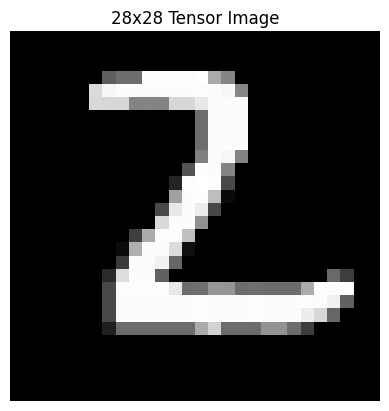

In [284]:
import matplotlib.pyplot as plt

def image_reshape(images):
    """
    Function to resize images from the dataloaders.

    Inputs:
    - images: tensor containing a batch of images.
    Shape: (batch_size, num_observed_vars)

    Outputs:
    - images: tensor containing a batch of resized images.
    Shape: (batch_size, image_height, image_width, image_channels)
    """

    images = images.reshape((-1, 1, 28, 28))
    return images

for (images, digits) in train_loader:
    images = image_reshape(images)
    print(images.shape)
    plt.imshow(images[0, 0, :, :], cmap='gray')
    plt.title("28x28 Tensor Image")
    plt.axis('off')  # Hide axes
    plt.show()

    break

### Loss Functions

In [285]:
#Some functions to compute loss

def multivariate_normal_KL_divergence(mu_1, sigma_1, mu_2, sigma_2):
  """
  Function to compute KL divergence between two multivariate normal distributions. 
  This has closed form, as shown in https://arxiv.org/pdf/1606.05908.

  This function is NOT vectorised.

  Inputs:
  - mu_1: a vector of means for distribution 1.
  - sigma_1: a covariance matrix for distribution 1.
  - mu_2: a vector of means for distribution 2.
  - sigma_2: a covariance matrix for distribution 2.

  Outputs:
  - KL_divergence: computed KL divergence, D(distribution_1, distribution_2).
  """

  #Initialise variables
  sigma_2_inv = torch.linalg.inv(sigma_2)
  k = len(mu_1)

  #Compute KL-divergence
  KL_divergence = 1/2 * ( torch.trace(sigma_2_inv @ sigma_1) + (mu_2 - mu_1).T @ sigma_2_inv @ (mu_2 - mu_1) - k + torch.log(torch.linalg.det(sigma_2) / torch.linalg.det(sigma_1)))

  return KL_divergence

def normal_KL_divergence_from_standard_normal(mu, sigma):
  """
  Function to compute KL divergence between the given normal distribution and the standard normal
  distribution, N(0, I). This is equivalent to multivariate_normal_KL_divergence(), except it is
  more efficient when the second distribution is the standard normal. Closed form is obtained from
  https://arxiv.org/pdf/1606.05908.

  This function is vectorised.

  Inputs:
  - mu: a vector of means for the distribution.
  Shape: (*, n_vars)
  - sigma: a covariance matrix for the distribution.
  Shape: (*, n_vars, n_vars)

  Outputs:
  - KL_divergence: computed KL divergence, D(distribution_1, N(0, I)).
  Shape: (*)
  """

  #Initialise variables
  k = mu.shape[-1]

  #Compute traces (vectorised)
  #Shape: (batch_size, n_vars)
  sigma_traces = sigma.diagonal(dim1=-2, dim2=-1).sum(-1)

  #Compute KL-divergence
  KL_divergence = 1/2 * ( sigma_traces + torch.sum(mu ** 2, dim = -1) - k - torch.linalg.slogdet(sigma)[1] )

  return KL_divergence

def extract_vector_X(images):
  """
  Function to resize a batch of images in the dataloader to tensors of shape 
  (batch_size, n_observed_vars). This is necessary since X is assumed to be from a multivariate
  normal distribution.

  Inputs:
  - images: a tensor for a batch of images from the dataloader. 
  Shape: (batch_size, 1, n_rows, n_cols)?

  Ouptuts: 
  - X: a resized tensor for a batch of images.
  Shape: (batch_size, n_rows, n_cols)
  """

  #Resize tensors
  X = torch.squeeze(images.flatten(start_dim = -2))

  return X
  
def loss_per_batch(X, z, Q_mu, Q_sigma, P_mu, P_sigma):
  """
  Function to compute loss over entire batch. In a VAE, this is the negative of the evidence lower bound (ELBO).
  We wish to maximise the ELBO, hence we minimise the negative ELBO.

  Note that we assume that the latent variables z are drawn from a multivariate standard normal dstribution, N(0, I).

  Here, "P" refers to our map from latent variables to data points, P(X|z).

  Inputs:
  - X: tensor containing the observed data points for a batch.
  Shape: (batch_size, n_observed_vars)
  - z: tensor containing the latent variables corresponding to the given observed data points.
  Note that we allow multiple latent variable samples for a single data point, as z_batch_size 
  does not need to be 1.
  Shape: (batch_size, z_batch_size, n_latent_vars)
  - Q_mu: vector of means for our normal surrogate distribution, Q(z|X). 
  Shape: (batch_size, n_latent_vars)
  - Q_sigma: covariance matrix for our normal surrogate distribution, Q(z|X). 
  Shape: (batch_size, n_latent_vars, n_latent_vars)
  - P_mu: vector of means for P. 
  Shape: (batch_size, z_batch_size, n_observed_vars)
  - P_sigma: covariance matrix for P. 
  Shape: (batch_size, z_batch_size, n_observed_vars, n_observed_vars)

  Outputs:
  - loss: a float for the loss to be maximised 
  """

  #Initialise variables
  #Number of latent and observed variables
  n_observed = X.shape[-1]
  n_latent = Q_mu.shape[-1]
  #Distributions for P=P(X|z) and Q=Q(z|X)
  P = torch.distributions.MultivariateNormal(P_mu, P_sigma)
  Q = torch.distributions.MultivariateNormal(Q_mu, Q_sigma)

  #Compute loss per data point
  #Note that Pytorch should automatically implement the reparametrisation trick here.
  P_log_likelihood = P.log_prob(X.reshape(batch_size, 1, n_observed).repeat(1, z_batch_size, 1))
  KL_divergence = normal_KL_divergence_from_standard_normal(Q_mu, Q_sigma)
  #Average log likelihood over all z samples
  loss = - torch.mean(P_log_likelihood, dim = 1) + KL_divergence

  return loss

print("All functions generated")

All functions generated


### Tests for the Functions Above

In [286]:
torch.manual_seed(42)

n_observed = 10
n_latent = 5

batch_size = 32

Z_mu = torch.zeros(n_latent)
Z_sigma = torch.eye(n_latent)
Z = torch.distributions.MultivariateNormal(Z_mu, Z_sigma)

Q_mu = Z.sample((batch_size,))
Q_sigma = torch.diag_embed(torch.abs(Z.sample((batch_size,))))

#Compute KL-divergence between Q and I manually
Q = torch.distributions.MultivariateNormal(Q_mu, Q_sigma)
expected_KL = torch.distributions.kl_divergence(Q, Z)
test_KL = normal_KL_divergence_from_standard_normal(Q_mu, Q_sigma)
manual_KL = torch.zeros((batch_size,))
for i in range(batch_size):
    manual_KL[i] = 1/2 * (torch.log(torch.linalg.det(Z_sigma) / torch.linalg.det(Q_sigma[i, :, :])) - n_latent + torch.trace(torch.linalg.inv(Z_sigma) @ Q_sigma[i, :, :]) + (Z_mu - Q_mu[i, :]).T @ torch.linalg.inv(Z_sigma) @ (Z_mu - Q_mu[i, :]))

#Test 1: normal_KL_divergence_from_standard_normal()
print(f"\n\nnormal_KL_divergence_from_standard_normal test.\nExpected value==Test Value: {torch.allclose(expected_KL, test_KL, atol=1e-5, rtol=1e-3)}.\nManually-calculated value == Expected Value: {torch.allclose(manual_KL, expected_KL, atol=1e-5, rtol=1e-3)}.\nManually-calculated value == Test Value: {torch.allclose(manual_KL, test_KL, atol=1e-5, rtol=1e-3)}")

#Test passed

#Initialise variables
z_batch_size = 3

#Create new distribution, P=P(X|z)
Z_mu = torch.zeros(n_observed)
Z_sigma = torch.eye(n_observed)
Z = torch.distributions.MultivariateNormal(Z_mu, Z_sigma)
P_mu = Z.sample((batch_size, z_batch_size))
P_sigma = torch.diag_embed(torch.abs(Z.sample((batch_size, z_batch_size))))
P = torch.distributions.MultivariateNormal(P_mu, P_sigma)

manual_P_log_likelihood = torch.zeros((batch_size, z_batch_size, n_latent))

#Sample a single batch of X
#In practice this would be conditioned on a sample of z from Q
X = P.sample((1,)).squeeze()[:, 0, :]

Z_mu = torch.zeros(n_latent)
Z_sigma = torch.eye(n_latent)
Z = torch.distributions.MultivariateNormal(Z_mu, Z_sigma)

#Sample z from Q, then compute log-likelihood of X given z
z = Q.rsample((z_batch_size,))
manual_P_log_likelihood = P.log_prob(X.unsqueeze(1).repeat(1, z_batch_size, 1))
manual_KL_divergence = torch.distributions.kl_divergence(Q, Z)

#Average over all z samples
manual_loss = -torch.mean(manual_P_log_likelihood, dim = 1) + manual_KL_divergence
test_loss = loss_per_batch(X, z, Q_mu, Q_sigma, P_mu, P_sigma)

#TEST 2: loss_per_batch
print(f"\n\nloss_per_batch test.\nExpected_value == Obtained_value: {torch.allclose(manual_loss, test_loss, atol=1e-5, rtol=1e-3)}.")
#Test passed



#TODO: Consider how we aggregate values. It will depend on whether testing or training, etc? Could use
#an aggregate_values function? Or maybe just leave everything and then during training we can take the
#sum, etc.


#TODO: fix dimensions - do we want the distribution to only have a single mean? <-- NO, best to vectorise
#over batch_size, then the number of samples in z_batch_size, right?




normal_KL_divergence_from_standard_normal test.
Expected value==Test Value: True.
Manually-calculated value == Expected Value: True.
Manually-calculated value == Test Value: True


loss_per_batch test.
Expected_value == Obtained_value: True.


### Neural Network

We will use Optuna to find the optimal set of hyperparameters.

In [287]:
#Create Neural Network Model
class neural_network(torch.nn.Module):
    """
    Create class for a neural network with a variable number of layers.
    """

    def __init__(self, hidden_sizes, n_inputs, n_outputs):
        """
        Initialise the model and relevant hyperparameters

        Inputs:
        - hidden_sizes: a list containing the number of neurons in each layer in the neural network.
        - n_inputs: the number of inputs to be produced by the neural network.
        - n_outputs: the number of outputs to be produced by the neural network.
        """

        super(neural_network, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        #Create a ModuleList to hold the layers
        self.layers = torch.nn.ModuleList()

        #Create layers of neural network
        in_size = n_inputs
        for out_size in hidden_sizes:
            self.layers.append(torch.nn.Linear(in_size, out_size))
            in_size = out_size #Update number of inputs for next layer
        self.layers.append(torch.nn.Linear(in_size, n_outputs))

    def forward(self, X):
        """ 
        Establish how inputs move through the neural network. This is where we set the 
        activation function.

        Inputs:
        - X: tensor of inputs.
        Shape: (batch_size, n_inputs)

        Outputs:
        - X: tensor of outputs.
        Shape: (batch_size, n_outputs)
        """

        for layer in self.layers:
            X = torch.nn.functional.relu(layer(X))

        return X

class VAE(torch.nn.Module):
    """      
    Create VAE model. The main goal is to estimate the following with neural networks:
    - f = f(z; theta): this is a map from latent variables to a point estimate for X, as we assume that
    P(X|z) has distribution N( f(z; theta), sigma^2*I ). 
    - mu = mu(X; phi) and sigma = sigma(X; phi): these parametrise Q(z|X), which we assume to have 
    distribution N( mu(X; phi), sigma(X; phi) ).
    """

    def __init__(self, n_observed, n_latent, f_hidden_sizes, Q_hidden_sizes, z_batch_size):
        """
        Initialise the model and relevant hyperparameters

        Inputs:
        - n_observed: the number of observed variables
        - n_latent: the number of latent variables
        - f_hidden_sizes: a list for the number of hidden sizes in the neural network f(z; theta).
        - Q_hidden_sizes: a list for the number of hidden sizes in the neural network for 
        the parameters of Q (mu(X; phi) and sigma(X; phi)).
        - z_batch_size: the number of latent variables to sample per observed data point.

        Notes:
        - self.n_outputs depends on the number of latent and observed variables. 
        - self.log_sigma2 is a parameter of the model, as it is not specific to each data point
        (homoscedastic variance). We use log variance, as then taking the exponential ensures varaince
        is positive.
        """

        super(VAE, self).__init__()

        #Initialise hyperparameters
        self.n_observed = n_observed
        self.n_latent = n_latent
        self.z_batch_size = z_batch_size

        #Initialise log variance. Note that this will be optimised
        self.log_sigma2 = torch.nn.Parameter(torch.tensor([0.0]))

        #Initialise instances of neural networks.
        #Recall that f maps z to X and Q maps X to z, so this determines the number of inputs and outputs.
        #For Q, mu and sigma both have n_latent elements, hence the total outputs is 2*n_latent.
        self.f_nn = neural_network(f_hidden_sizes, n_latent, n_observed)
        self.Q_n_outputs = 2*n_latent
        self.Q_nn = neural_network(Q_hidden_sizes, n_observed, self.Q_n_outputs)

    def forward(self, inputs, skip_encode = False):
        """
        Forward function for the VAE model. Here, we use Q to encode our data, then f to decode.

        Inputs:
        - inputs: depends on skip_encode (see below).
        - skip_encode: a boolean which determines whether "inputs" are observed data points or latent
        variables.
        if skip_encode == False:
            inputs is a tensor of observed data.
            Shape: (batch_size, n_observed)
        if skip_encode == True:
            inputs is a tensor of latent variables.
            Shape: (batch_size,  z_batch_size, n_latent)

        Outputs:
        - outputs: a tuple, where the elements depends on skip_encode.
        if skip_encode == False:
            - z: samples from Q, which represent likely latent variables corresponding to each observed
            data point.
            Shape: (batch_size, z_batch_size, n_latent)
            - Q_mu & Q_sigma: tensors containing the mean and variance for our surrogate distribution, 
            Q=Q(z|X), respectively. 
            Shapes: (batch_size, n_latent) & (batch_size, n_latent, n_latent).
            - P_mu & P_sigma: tensors containing the mean and variance for our decoder, P=P(X|z), 
            respectively. 
            Shapes: (batch_size, z_batch_size, n_observed) & (batch_size, z_batch_size, n_observed, n_observed).
        if skip_encode == True:
            - P_mu & P_simga: see above.

        Note that point estimates for the reconstructed data is given by P_mu = f(z; theta).

        """

        #Initialise variables
        batch_size = inputs.shape[0]

        if skip_encode == True:
            #Relabel inputs
            z = inputs

        else:
            #Relabel inputs
            X = inputs

            #Encode data as probability distributions
            #Elements of variance matrix must be positive, so take exponential.
            Q_parameters = self.Q_nn(X)
            Q_mu = Q_parameters[:, 0:self.n_latent]
            Q_sigma = torch.exp(Q_parameters[:, self.n_latent:])
            Q_sigma =  torch.diag_embed(Q_sigma)

            #Sample from Q to get encoded variables.
            #Permute dimensions so that z has the intended shape: (batch_size, z_batch_size, n_latent)
            Q = torch.distributions.MultivariateNormal(Q_mu, Q_sigma)
            z = Q.rsample((self.z_batch_size,))
            z = torch.movedim(z, 0, 1) 

        #Decode sampled latent variables.
        #Here, f is the point estimate for X, i.e. it is our reconstructed observed data.
        f = self.f_nn(z)
        P_mu = f
        P_sigma = torch.exp(self.log_sigma2) * torch.eye(self.n_observed)
        #Reshape P_sigma
        P_sigma = P_sigma.reshape(1, 1, self.n_observed, self.n_observed).repeat(batch_size, self.z_batch_size, 1, 1)

        #Outputs depend on whether we skipped encoding or not
        if skip_encode == True:
            outputs = ( P_mu, P_sigma )
        else: 
            outputs = ( z, Q_mu, Q_sigma, P_mu, P_sigma )
        return outputs



Test function for VAE model

In [288]:
#Extract a single batch
for images, digits in train_loader:
    break

#Initialise hyperarameters
n_observed = images.shape[-1]
n_latent = 5
f_hidden_sizes = [10, 12]
Q_hidden_sizes = [20, 24, 28]
sigma = 1
z_batch_size = 7

test_model = VAE(n_observed, n_latent, f_hidden_sizes, Q_hidden_sizes, z_batch_size)

#Test full model
Q_mu, Q_sigma, z, P_mu, P_sigma = test_model(images, skip_encode = False)
print(f"Q_mu.shape: {Q_mu.shape}, Q_sigma.shape: {Q_sigma.shape}, z.shape: {z.shape}, P_mu.shape: {P_mu.shape}, P_sigma.shape: {P_sigma.shape}")

#Test only decder
z = torch.distributions.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)).sample((z_batch_size, n_latent))
print("z.shape: ", z.shape)

Q_mu.shape: torch.Size([4, 7, 5]), Q_sigma.shape: torch.Size([4, 5]), z.shape: torch.Size([4, 5, 5]), P_mu.shape: torch.Size([4, 7, 784]), P_sigma.shape: torch.Size([4, 7, 784, 784])
z.shape:  torch.Size([7, 5, 5])


### Functions to Train and Evaluate VAE

In [ ]:
import optuna

def train_VAE(train_loader, model, n_epochs, optimiser):
  """
  Function to train the VAE.

  Inputs:
  - train_loader: the `DataLoader` object for the training dataset.
  - model: the VAE model to be trained.
  - n_epochs: number of times to loop through entire dataset during optimisation.
  
  Outputs:
  - model: trained VAE model.
  - loss: total training loss for the model
  """

  #Initialise variables
  n_batches = len(train_loader)
  batch_sizes = [len(batch) for batch in train_loader]
  loss_by_epoch = [0 for _ in range(n_epochs)]
  #Only want to print every 10% per epoch
  checkpoints = [torch.ceil(torch.tensor(n_batches/10) * (i)) for i in range(10+1)]
  i = 0

  #Loop through entire dataset the specified number of times
  for epoch_index in range(n_epochs):
    for batch_index, (images, digits) in enumerate(train_loader):
      #Compute loss
      z, Q_mu, Q_sigma, P_mu, P_sigma = model(images, skip_encode = False)
      batch_loss = torch.sum(loss_per_batch(images, z, Q_mu, Q_sigma, P_mu, P_sigma))
      loss_by_epoch[epoch_index] += batch_loss
      
      #Update parameters based on optimiser
      optimiser.zero_grad()
      batch_loss.backward()
      optimiser.step()

      #Only print occasional batch statistics
      if batch_index == checkpoints[i]:
        print(f"Batch number: {batch_index}/{n_batches}. Average batch loss: {batch_loss / batch_sizes[batch_index]}")
        i += 1
        
  print(f"\n\nEpoch number: {epoch_index}/{n_epochs}. Total epoch loss: {loss_by_epoch[epoch_index]}.\nEpoch loss history: {loss_by_epoch}\n\n")

  return model, loss




def test_VAE(test_loader, model, loss_history):
  """
  Function to test the VAE.

  Inputs:
  - test_loader: the `DataLoader` object for the testing dataset.
  - model: the VAE model to be trained.
  - loss_history: a list of previous test losses (to be able to print the historical loss).

  Outputs:
  - loss: total training loss for the model
  """

  #Initialise variables
  loss = 0

  #Loop through dataset
  for batch_index, (images, digits) in enumerate(train_loader):      
      #Compute loss
      z, Q_mu, Q_sigma, P_mu, P_sigma = model(images, skip_encode = False)
      batch_loss = torch.sum(loss_per_batch(images, z, Q_mu, Q_sigma, P_mu, P_sigma))
      loss += batch_loss

  print(f"\n\nTest loss: {loss}.\nTest loss history: {loss_history.append(loss)}\n\n")

  return loss


def objective(trial, train_loader, test_loader, n_latent, z_batch_size, n_epochs, loss_history):
  """  
  Objective function for Optuna to optimise. Here, hyperparameters are suggested by the package.
  
  Inputs:
  - trial: optuna.trial.Trial object
  - train_loader & test_loader: dataloaders for the training and testing datasets.
  - n_latent: number of latent variables for each data point.
  - z_batch_size: number of latent samples per data point to compute gradient.
  - n_epochs: number of times to loop through entire dataset.
  - loss_history: a list of previous test losses (to be able to print the historical loss).

  Outputs:
  - loss: scalar value for the loss across the entire test dataset.
  """

  #Suggest hyperparameters
  n_latent = trial.suggest_int("n_latent", 5, 50)
  f_n_layers = trial.suggest_int("n_layers", 1, 3)
  Q_n_layers = trial.suggest_int("n_layers", 1, 3)
  #We will start with all layers having equal size
  f_hidden_size = trial.suggest_int("hidden_size", 32, 128)
  Q_hidden_size = trial.suggest_int("hidden_size", 32, 128)
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
  #dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)

  #Initialise variables and other hyperparameters
  f_hidden_sizes = [f_hidden_size for _ in range(f_n_layers)]
  Q_hidden_sizes = [Q_hidden_size for _ in range(Q_n_layers)]
  for (images, digits) in train_loader:
    break
  #Number of observed variables is product of all dimension lengths except first (batch)
  n_observed = torch.prod(torch.tensor(images[(0,) + (slice(None),) * (images.dim() - 1)].shape))

  #Initialise model and optimiser
  model = VAE(n_observed, n_latent, f_hidden_sizes, Q_hidden_sizes, z_batch_size)
  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  #Train model
  model, _ = train_VAE(train_loader, model, n_epochs, optimiser)

  #Test model
  loss = test_VAE(test_loader, model, loss_history)
  loss_history.append(loss)

  return loss
  


### Run Training and Testing

In [ ]:
#Initialise hyperparameters
for (images, digits) in train_loader:
    break
batch_size = images.shape[0]
z_batch_size = 1
n_epochs = 10
loss_history = []

# Run the study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_loader, test_loader, n_latent, z_batch_size, n_epochs, loss_history), n_trials=100)

# Best result
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(f"  Params: {trial.params}")

[I 2025-05-17 07:46:11,096] A new study created in memory with name: no-name-777324a1-e32a-4e3e-9adf-f0cd5d773b02


checkpoints:  [tensor(0.), tensor(1500.), tensor(3000.), tensor(4500.), tensor(6000.), tensor(7500.), tensor(9000.), tensor(10500.), tensor(12000.), tensor(13500.)]
Batch number: 0/15000. Average batch loss: 2218.64208984375
Batch number: 1500/15000. Average batch loss: 2169.84423828125


[W 2025-05-17 07:51:59,334] Trial 0 failed with parameters: {'n_latent': 47, 'n_layers': 3, 'hidden_size': 32, 'lr': 0.0024357293573215037} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\kperc\VAE\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\kperc\AppData\Local\Temp\ipykernel_45484\2390069452.py", line 11, in <lambda>
    study.optimize(lambda trial: objective(trial, train_loader, test_loader, n_latent, z_batch_size, n_epochs, loss_history), n_trials=100)
                                 ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kperc\AppData\Local\Temp\ipykernel_45484\3003194568.py", line 118, in objective
    model, _ = train_VAE(train_loader, model, n_epochs, optimiser)
               ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kperc\AppData\Local\Temp\ip

KeyboardInterrupt: 

## Notes

- Will use $P(X|z) = N(X|f(z; \theta), \sigma^2 * I)$ for a loss function. We wish to maximise this, or equivalently to minimise $-P(X|z)$.
- Could simplify by only feeding through distributions to loss function and leaving it to Pytorch to compute KL-divergence. This would be very simple and allows generalisation to non-normal distributions.
- We will start by minimising $\sigma^2$ as a global parameter, like in the textbook "Understanding 
Deep Learning". But, could improve this in the future.
- Currently estimating $\mu(X; \phi)$ and $\Sigma(X; \phi)$ through a single neural network, although
could separate this...

### TODO - basic
- Check: we have to sample z from Q before we can actually train the neural network f, right?
- Consider how to optimise sigma globally in practice.
- Must add function to ensure that output of VAE is in the correct form, i.e. a picture of integers between 0 and 255?
- Add dropout or some other bells and whistles?

### TODO - future
- Add preprocessing - is it best practice to standardise variables to have mean 0 and variance 1?
- Add conditional VAE theory
- Add recent research in Beta-Sigma VAE: https://arxiv.org/pdf/2409.09361